<h1> Script predicción</h1> 
<h2> The Backpropagation Boyz </h2>

# Librerias y funciones  

In [2]:
import numpy as np 
import os 
import tensorflow as tf
import sklearn 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#clustering
from scipy.cluster.hierarchy import complete,single, fcluster,dendrogram
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
import datetime
import seaborn as sns




#esta funcion coge series como input y las secciona, dando n puntos iniciales (feature) y los m siguientes (labels)

def window(data_big,size_input,size_output=None,data_aux=None):
  if size_output is not None:
    #esto para implementar que se devuelvan ventanas mas grandes
    features=[]
    labels=[]
    #if data_aux is not None:
      #data_aux=data_aux.T

    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -size_output):
        if data_aux is not None:
          data_aux_slice=data_aux[j:(j+size_input),:]
          features.append(np.hstack([data[j:(j+size_input)][...,np.newaxis],data_aux_slice]))
        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[(j+size_input):(j+size_input+size_output)])
  else:
    features=[]
    labels=[]
    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -1):
        if data_aux is not None:
          data_aux_slice=data_aux[j:(j+size_input),:]
          features.append(np.hstack([data[j:(j+size_input)][...,np.newaxis],data_aux_slice]))
        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[j+size_input+1])
  return np.array(features),np.array(labels)  



#funcion que coge una serie temporal, un modelo y va predicciendo todo lo que puede 
#si toma inputs de 20 y devuelve 7, va prediciendo asi la serie temporal (de 7 en en 7 conociendo los 20 anteriores)
def pred_model2(model,ts,window):
  input_size=model.input_shape[1]
  leng=ts.shape[0]
  preds=[]
  for i in range(input_size,leng-window,window):
    preds.append(model.predict(ts[(i-input_size):i][np.newaxis,...])[0])
  return np.array(preds)

# Carga y preprocesado de datos

Comenzamos ordenando las muestras del fichero.

In [2]:
!sort Modelar_UH2022.txt > Modelar_UH2022_sorted.txt

In [3]:
!head Modelar_UH2022_sorted.txt

0|2019-02-01 00:39:36|331710|0|0|0
0|2019-02-01 01:39:36|331710|0|0|0
0|2019-02-01 02:39:35|331710|0|0|0
0|2019-02-01 03:39:35|331710|0|0|0
0|2019-02-01 04:39:35|331710|0|0|0
0|2019-02-01 05:39:35|331710|0|0|0
0|2019-02-01 06:39:35|331710|0|0|0
0|2019-02-01 07:39:35|331729|0|19|0
0|2019-02-01 08:39:35|331765|0|36|0
0|2019-02-01 09:39:35|331765|0|0|0


La cabecera se ha quedado al final, vamos a moverla al principio.

In [4]:
!sed '1h;1d;$!H;$!d;G' Modelar_UH2022_sorted.txt > tmp.txt; mv tmp.txt Modelar_UH2022_sorted.txt

In [5]:
!head Modelar_UH2022_sorted.txt

ID|SAMPLETIME|READINGINTEGER|READINGTHOUSANDTH|DELTAINTEGER|DELTATHOUSANDTH
0|2019-02-01 00:39:36|331710|0|0|0
0|2019-02-01 01:39:36|331710|0|0|0
0|2019-02-01 02:39:35|331710|0|0|0
0|2019-02-01 03:39:35|331710|0|0|0
0|2019-02-01 04:39:35|331710|0|0|0
0|2019-02-01 05:39:35|331710|0|0|0
0|2019-02-01 06:39:35|331710|0|0|0
0|2019-02-01 07:39:35|331729|0|19|0
0|2019-02-01 08:39:35|331765|0|36|0


No nos interesan los datos de cada hora, vamos a agregarlos para tener la información diaria de cada deposito. Asimismo, tendremos en cuenta un solo valor sin decimales.

In [6]:
!rm Modelar_UH2022_agg.txt

rm: cannot remove 'Modelar_UH2022_agg.txt': No such file or directory


In [7]:
file1 = open('Modelar_UH2022_sorted.txt', 'r')
file2 = open('Modelar_UH2022_agg.txt', 'a')
iden_pre = ""
curr_delta = 0
curr_reading = 0

for i, line in enumerate(file1.readlines()):
    if i != 0:
        iden, content  = line.split()
        content = content.split('|')

        if '' in content: content = ['0' if c == '' else c for c in content]

        if iden != iden_pre and i!= 1:

            file2.write(iden_pre+'|'+ str(curr_reading)+'|'+str(curr_delta)+'\n')
            curr_delta = 0

            
        curr_reading = int(content[1])*100 + int(content[2])*(10**(2-len(content[2])))

        curr_delta += int(content[3])*100 + int(content[4])*(10**(2-len(content[2])))

        iden_pre = iden

    else:
        file2.write('ID|SAMPLETIME|READING|DELTA\n')

file1.close()
file2.close()

In [8]:
!rm Modelar_UH2022_sorted.txt

In [3]:
ds = pd.read_csv("Modelar_UH2022_agg.txt", sep='|')

In [4]:
ds.head()

,ID,SAMPLETIME,READING,DELTA
0,0,2019-02-01,33195300,24300
1,0,2019-02-02,33218900,23600
2,0,2019-02-03,33252400,33500
3,0,2019-02-04,33277600,25200
4,0,2019-02-05,33299600,22000


In [111]:
df = pd.DataFrame()
dates = sorted(ds['SAMPLETIME'].unique())
df['DATE'] = dates

In [112]:
for i, idd in enumerate(sorted(ds['ID'].unique())):
    filtered = ds[ds['ID'] == idd]
    colname = 'DELTA_ID' + str(i+1)
    df[colname] = df.merge(filtered, how='left', left_on='DATE', right_on='SAMPLETIME')['DELTA']

In [ ]:
df.to_csv('consumo_aggbyday_filledzeros_samelength.csv')

In [113]:
datos = df# pd.read_csv('consumo_aggbyday_filledzeros_samelength.csv')
print(datos.head())

         DATE  DELTA_ID1  DELTA_ID2  DELTA_ID3  DELTA_ID4  DELTA_ID5  \
0  2019-02-01      24300        800          0      49200      25260   
1  2019-02-02      23600       4700          0      38100      24171   
2  2019-02-03      33500        600          0      31300      26641   
3  2019-02-04      25200       1200          0      36200      41200   
4  2019-02-05      22000       4400          0      38000      26900   

   DELTA_ID6  DELTA_ID7  DELTA_ID8  DELTA_ID9  ...  DELTA_ID2738  \
0      44496       8000       4500        400  ...           NaN   
1          0       1100       3600          0  ...           NaN   
2          0       6900      42600          0  ...           NaN   
3          0      27196      43300        700  ...           NaN   
4          0      23092       6300          0  ...           NaN   

   DELTA_ID2739  DELTA_ID2740  DELTA_ID2741  DELTA_ID2742  DELTA_ID2743  \
0           NaN           NaN           NaN           NaN           NaN   
1       

In [114]:
lectura = datos.iloc[:,1:].fillna(0,inplace=False).to_numpy().T

#vamos a suavizar todo y a escalarlo
data_filtered = ndimage.gaussian_filter(lectura,[0,3],0)
scaler=MinMaxScaler()
data_pre=scaler.fit_transform(data_filtered.T).T

# Clustering jerarquico

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


(197, 365)
(1062, 365)
(757, 365)
(731, 365)


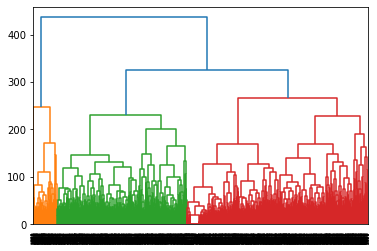

In [115]:
d=pairwise_distances(data_pre)
a=complete(d)
dendrogram(a);
ind=fcluster(a,4,"maxclust")
#sacamos los subgrupos, escogemos solo 4
datos_g=[]
for i in range(1,5):
  datos_g.append(data_pre[ind==i])
  print(datos_g[i-1].shape)


# Entrenamiento

In [116]:
feat,labs=window(datos_g[1],20,7)
print(labs.shape,feat.shape)
x_train,x_test,y_train,y_test= train_test_split(feat,labs,test_size=0.2)


(358956, 7) (358956, 20)


In [117]:
#la creamos
input=tf.keras.layers.Input(shape=[20,1])
x=tf.keras.layers.LSTM(30,return_sequences=True)(input)
x=tf.keras.layers.LSTM(60,return_sequences=False)(x)
x=tf.keras.layers.Dense(50,activation="relu",kernel_regularizer="l2")(x)
x=tf.keras.layers.Dense(7,activation="sigmoid",kernel_regularizer="l2")(x)

model=tf.keras.Model(input,x)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 30)            3840      
                                                                 
 lstm_3 (LSTM)               (None, 60)                21840     
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                                 
 dense_3 (Dense)             (None, 7)                 357       
                                                                 
Total params: 29,087
Trainable params: 29,087
Non-trainable params: 0
_________________________________________________________________


In [118]:
#la entrenamos
model.compile(optimizer="adam",loss="mse")
hist=model.fit(x_train,y_train,epochs=20,batch_size=128,validation_split=0.2)

Epoch 1/20
1795/1795 [==============================] - 61s 32ms/step - loss: 0.0580 - val_loss: 0.0242
Epoch 2/20
1795/1795 [==============================] - 58s 32ms/step - loss: 0.0226 - val_loss: 0.0216
Epoch 3/20
1795/1795 [==============================] - 58s 32ms/step - loss: 0.0206 - val_loss: 0.0197
Epoch 4/20
1795/1795 [==============================] - 58s 32ms/step - loss: 0.0195 - val_loss: 0.0194
Epoch 5/20
1795/1795 [==============================] - 58s 33ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 6/20
1795/1795 [==============================] - 58s 32ms/step - loss: 0.0184 - val_loss: 0.0182
Epoch 7/20
1795/1795 [==============================] - 58s 32ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 8/20
1795/1795 [==============================] - 58s 32ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 9/20
1795/1795 [==============================] - 58s 32ms/step - loss: 0.0177 - val_loss: 0.0176
Epoch 10/20
1795/1795 [==============================] - 58s 32m

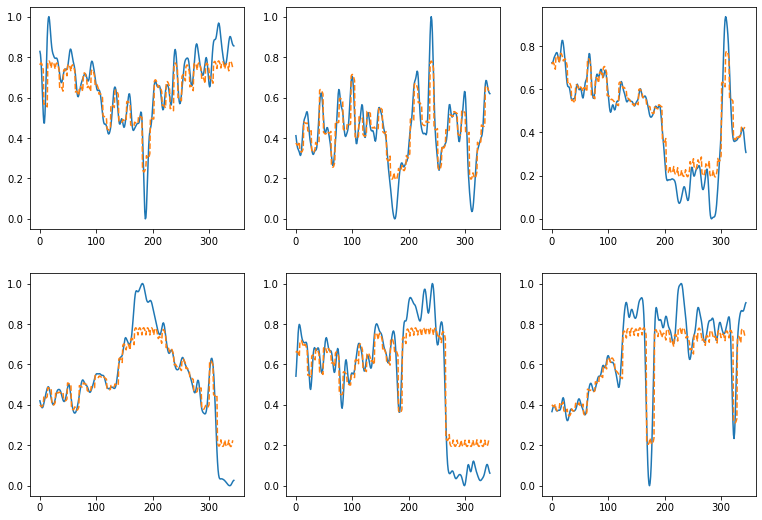

In [119]:
#veamos los resultados
plt.figure(figsize=(13,9))
for i,m in enumerate([23,56,76,43,12,65]):
  plt.subplot(2,3,i+1)
  a=pred_model2(model,datos_g[1][m],7)
  a.shape
  a=a.flatten()
  plt.plot(datos_g[1][m][20:])
  plt.plot(a,"--")

In [120]:
#hay un problema y es que los datos estan normalizados, entonces, tenemos que devolverlos a las magnitudes iniciales
#eso lo vamos a hacer con una funcion
def predict_norm(model,datos):
  scaler=MinMaxScaler()
  x=scaler.fit_transform(datos)
  y_pred=model.predict(x)
  y=scaler.inverse_transform(y_pred)
  return y